In [1]:
import sys
from pathlib import Path
from argparse import ArgumentParser, Namespace
from collections import Counter
import pickle
from typing import List, Dict, Tuple, Optional, Union

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import geopandas as gdp
from tqdm import tqdm

sys.path.append("..")

from src.models import STR2MODEL
from src.engineer import GeoWikiEngineer, NigeriaEngineer
from src.exporters.sentinel.cloudfree import BANDS

%reload_ext autoreload
%autoreload 2

In [2]:
# Helper functions
def get_normalizing_dict(engineer: Union[GeoWikiEngineer, NigeriaEngineer], dict_path: Path, per_class: bool=False, per_country: bool=False, countries: Optional[List[str]]=None) -> Dict:
    
    # Get files over which to iterate with
    files = []
    if per_country:
        assert isinstance(engineer, GeoWikiEngineer), 'per_region only works for Geowiki data, engineer must be an instance of the GeowikiEngineer class.'
        assert countries is not None, 'You need to pass a country name or list of country names in region if you per_region=True. '
        for country in countries:
            files.extend(engineer.get_geospatial_files_per_country(engineer.data_folder, country))
    else:
        files.extend(engineer.geospatial_files)
    
    # Calculate and save normalizing dict (mean and std per band) or load it
    if not dict_path.exists():
        # Will process each tiff and save internally the running mean and variance
        for file_path in tqdm(files):
            file_info = engineer.process_filename(file_path.name, include_extended_filenames=True)
            if file_info is None:
                continue
            identifier, start_date, end_date = file_info

            instance = engineer.process_single_file(
                file_path,
                nan_fill=0.0,
                max_nan_ratio=0.3,
                add_ndvi=True,
                calculate_normalizing_dict=True,
                start_date=start_date,
                days_per_timestep=30,
                is_test=False)

        # Calculate mean and std from the mean and variance
        if per_class:
            normalizing_dict = engineer.calculate_normalizing_dict_per_class()
        else:
            normalizing_dict = engineer.calculate_normalizing_dict()

        # Save dictionary
        with dict_path.open("wb") as f:
            pickle.dump(normalizing_dict, f)
            print(f"Saved normalizing dict {dict_path.name} generated with {engineer.__class__} at {dict_path}.")
            
    else:
        with dict_path.open("rb") as f:
            normalizing_dict = pickle.load(f)
        print(f"Loaded normalizing dict {dict_path.name} of {engineer.__class__}.")
    
    return normalizing_dict

def plot_band_distributions(bands: List[str], means_all: List[Tuple[np.array]], stdevs_all: List[Tuple[np.array]], labels: List[str], colors: List[str], class_name: str='', is_cropland: bool=False) -> None:
    # NOTE: We take advantage of is_cropland=False=0 to select the first element of a single-element-tuple when we're not plotting per class.
    
    assert len(means_all) == len(stdevs_all) == len(labels) == len(colors), 'There must be as many labels as there are data subsets to plot.' 
    # TODO: add check of length of means and stdevs equal and equal to number of bands

    num_plots = len(bands)
    n_cols = 4
    n_rows = num_plots // n_cols if num_plots % n_cols == 0 else num_plots // n_cols + 1

    fig, axs = plt.subplots(n_cols, n_rows, figsize=(20, 15))
    x_axis = np.arange(-0.5, 1, 0.01)

    for band in range(num_plots):
        
        ax = plt.subplot(n_cols, n_rows, band + 1)
        
        for i, (means, stdevs) in enumerate(zip(means_all, stdevs_all)):
            mean = means[is_cropland][band]
            stdev = stdevs[is_cropland][band]
            ax.fill_between(x_axis, norm.pdf(x_axis, mean, stdev), color=colors[i], alpha=0.5, label=f'\u03BC={mean:.4f}, \u03C3={stdev:.4f}')
        
        # Subplot level
        ax.set_title(f'{bands[band]}')
        plt.legend()

    # Figure level    
    fig.legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=14, ncol=2)
    plt.subplots_adjust(top=0.85, hspace=0.5)
    fig.suptitle(f'Data distribution per band/feature {class_name}', fontsize=24)


def plot_band_distributions_per_class(bands: List[str], means_all: List[Tuple[np.array]], stdevs_all: List[Tuple[np.array]], labels: List[str], colors: List[str], per_class: bool=False) -> None:

    if per_class:
        for is_cropland in [False, True]:
            class_name = 'cropland' if is_cropland else 'non-cropland'
            plot_band_distributions(bands, means_all, stdevs_all, labels, colors, class_name, is_cropland)
    else:
        plot_band_distributions(bands, means_all, stdevs_all, labels, colors, '', False)

## Initialize model

Adding args=[] makes it work for Jupyter notebook https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook

In [3]:
# Get model default args
parser = ArgumentParser()
model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[]) 
model_args_dict = vars(model_args)

# Change default hyperparameters
model_args_dict['add_togo'] = False
model_args_dict['multi_headed'] = False
model_args_dict['num_classification_layers'] = 1

# Initialize model
model_args = Namespace(**model_args_dict)
model = STR2MODEL["land_cover"](model_args)
model.hparams

Number of geowiki instances in training set: 27947


Namespace(add_geowiki=True, add_togo=False, alpha=10, batch_size=64, data_folder='/home/gajo/code/togo-crop-mask/notebooks/../data', hidden_vector_size=64, learning_rate=0.001, rnn_dropout=0.2, model_base='lstm', multi_headed=False, num_classification_layers=1, num_rnn_layers=1, probability_threshold=0.5, remove_b1_b10=True)

## 1. Labels distribution

### 1a. Geowiki train and validation

Training set

In [4]:
train_loader = model.train_dataloader()
counter = Counter()
for sample in train_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in training set: 27947


In [5]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 22.1%
Non-cropland: 77.9%


Validation set


In [6]:
val_loader = model.val_dataloader()
counter = Counter()
for sample in val_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in validation set: 7301


In [7]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 21.2%
Non-cropland: 78.8%


### 1b. Nigeria farmlands test set

In [8]:
test_loader = model.test_dataloader()
counter = Counter()
for sample in test_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Evaluating using the Nigeria evaluation dataset!
Number of instances in nigeria_farmlands_v2 test set: 739


In [9]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 53.2%
Non-cropland: 46.8%


<font color='magenta'> **The target dataset has a very different balance of labels, many more cropland labels compared to training and validation set!** </font>

## 2. Data distribution both classes

Mean and std of each bands in a nice plot. Use normalizing dicts. Normalizing dict has 14 bands but my model has only 12, so we need to get the means and stdevs of only the bands the model is using.

In [10]:
# Get all bands names
full_bands = BANDS + ['NDVI'] if (model.input_size == 12) or (model.input_size == 14) else BANDS
bands_to_remove = ["B1", "B10"] if model.hparams.remove_b1_b10 else []

# Get band names that we use
indices_to_remove = []
for band in bands_to_remove:
    indices_to_remove.append(full_bands.index(band))
indices_to_keep = [i for i in range(len(full_bands)) if i not in indices_to_remove]
bands = [full_bands[index] for index in indices_to_keep]

### 2a. Geowiki train and val

In [11]:
geowiki_engineer = GeoWikiEngineer(Path('../data'))
geowiki_savedir = geowiki_engineer.data_folder / "features" / geowiki_engineer.dataset
dict_path = geowiki_savedir / "normalizing_dict.pkl"

normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path)

Loaded normalizing dict normalizing_dict.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [12]:
# Keep only means and stdevs of bands we have
means_geowiki_full = normalizing_dict['mean'][indices_to_keep]
stdevs_geowiki_full = normalizing_dict['std'][indices_to_keep]

In [13]:
means_geowiki_full, stdevs_geowiki_full

(array([0.17112217, 0.16083624, 0.16354993, 0.18635676, 0.25554994,
        0.29061711, 0.28009877, 0.31469831, 0.10141977, 0.22964706,
        0.15255525, 0.3221835 ]),
 array([0.15265479, 0.14360899, 0.16329558, 0.15796025, 0.14746618,
        0.15011357, 0.14306833, 0.14913972, 0.09338568, 0.1111936 ,
        0.09549155, 0.23958353]))

### 2b. Only Geowiki Nigeria

In [14]:
dict_path = geowiki_savedir / "normalizing_dict_Nigeria.pkl"
normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path, per_class=False, per_country=True, countries=['Nigeria'])

Loaded normalizing dict normalizing_dict_Nigeria.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [15]:
# Keep only means and stdevs of bands we have
means_geowiki_nigeria = normalizing_dict['mean'][indices_to_keep]
stdevs_geowiki_nigeria = normalizing_dict['std'][indices_to_keep]

In [16]:
means_geowiki_nigeria, stdevs_geowiki_nigeria

(array([0.15560102, 0.15790566, 0.17260478, 0.19427514, 0.2625466 ,
        0.30316053, 0.2888348 , 0.33543252, 0.07801849, 0.31987291,
        0.21970325, 0.27750435]),
 array([0.06552471, 0.06600064, 0.08697233, 0.08081589, 0.07260997,
        0.07892246, 0.07323694, 0.08107441, 0.05376292, 0.11082587,
        0.10423164, 0.17315761]))

### 2c. Geowiki regional: Nigeria + Cameron + Benin + Togo + Ghana

In [17]:
countries = ['Nigeria', 'Cameroon', 'Benin', 'Togo', 'Ghana']
countries_underscore_str = '_'.join(countries)
dict_filename = 'normalizing_dict_' + countries_underscore_str + '.pkl'
dict_path = geowiki_savedir / dict_filename
normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path, per_class=False, per_country=True, countries=countries)

Loaded normalizing dict normalizing_dict_Nigeria_Cameroon_Benin_Togo_Ghana.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [18]:
means_geowiki_regional = normalizing_dict['mean'][indices_to_keep]
stdevs_geowiki_regional = normalizing_dict['std'][indices_to_keep]

In [19]:
means_geowiki_regional, stdevs_geowiki_regional

(array([0.15639622, 0.15478129, 0.16052005, 0.18210957, 0.25861192,
        0.30205652, 0.28616927, 0.3337731 , 0.07249666, 0.29148372,
        0.19433004, 0.3125438 ]),
 array([0.08016264, 0.07900642, 0.09663687, 0.08940903, 0.08163167,
        0.08889727, 0.08184323, 0.09073389, 0.05365633, 0.10828142,
        0.10158471, 0.19213894]))

### 2d. Nigeria farmlands test set

Generate normalizing dictionary for nigeria farmlands test set. For normalizing the test isntances we use the mean and std from train and val set, but we save the test set one anyways for EDA on test set data distribution.

In [20]:
nigeria_engineer = NigeriaEngineer(Path('../data'))
nigeria_savedir = nigeria_engineer.data_folder / "features" / nigeria_engineer.dataset
dict_path = nigeria_savedir / "normalizing_dict.pkl"
normalizing_dict = get_normalizing_dict(nigeria_engineer, dict_path)


Loaded normalizing dict normalizing_dict.pkl of <class 'src.engineer.nigeria.NigeriaEngineer'>.


In [21]:
means_nigeria_farmlands = normalizing_dict['mean'][indices_to_keep]
stdevs_nigeria_farmlands = normalizing_dict['std'][indices_to_keep]

In [22]:
means_nigeria_farmlands, stdevs_nigeria_farmlands

(array([0.15616155, 0.14851976, 0.14194652, 0.1609707 , 0.24909862,
        0.29521354, 0.27295595, 0.32101549, 0.05851184, 0.24645745,
        0.15521237, 0.33682516]),
 array([0.08881402, 0.08582293, 0.09439774, 0.0881368 , 0.08671245,
        0.09435504, 0.0885216 , 0.09639167, 0.05606956, 0.07416003,
        0.06667968, 0.16890977]))

### Visualize distributions

In [23]:
# Data and config
means_all = [
    (means_geowiki_full,),
    (means_geowiki_regional,),
    (means_geowiki_nigeria,),
    (means_nigeria_farmlands,),
]

stdevs_all = [
    (stdevs_geowiki_full,),
    (stdevs_geowiki_regional,),
    (stdevs_geowiki_nigeria,),
    (stdevs_nigeria_farmlands,),
]

countries_plus_str = ' + '.join(countries)
labels = ['Geowiki full', f'Geowiki regional ({countries_plus_str})', 'Geowiki Nigeria', 'Nigeria farmlands (test set)']

colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green']

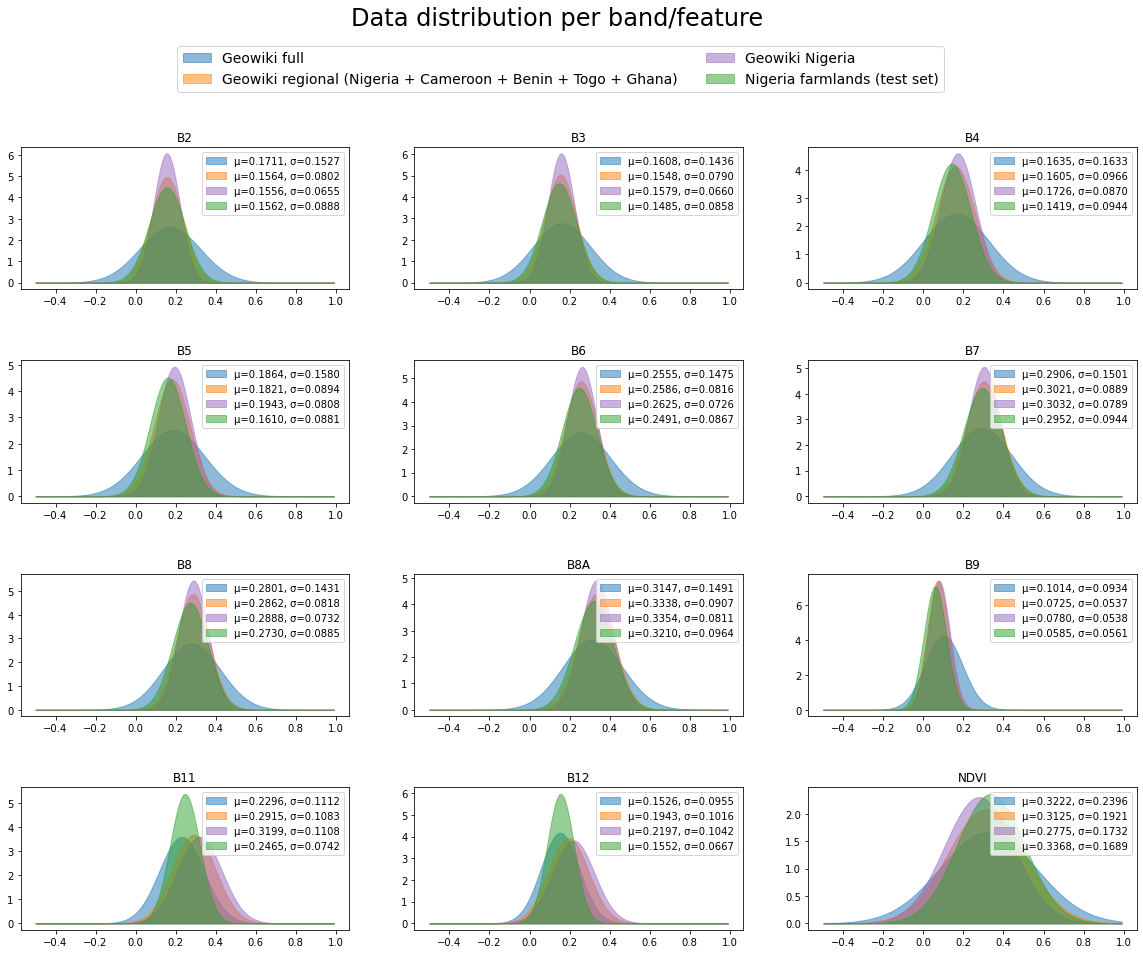

In [24]:
plot_band_distributions(bands, means_all, stdevs_all, labels, colors)

<font color='magenta'>
    <ul> 
        <li> The data distribution of the Nigeria farmlands test set has similar mean but a much lower variance compared to geowiki.
        <li> Geowiki Nigeria is close to test distribution. However, some bands are different due to sampling bias of Nigeria farmlands (no points in the North dessert), and shift of year. 
    </ul>    
</font>

## 3. Data distribution per class

### 3a. Geowiki train and val

In [25]:
dict_path = geowiki_savedir / "normalizing_dict_per_class.pkl"
normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path, per_class=True)

Loaded normalizing dict normalizing_dict_per_class.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [26]:
# Keep only means and stdevs of bands we have
means_geowiki_full_crop = normalizing_dict['mean_crop'][indices_to_keep]
means_geowiki_full_noncrop = normalizing_dict['mean_noncrop'][indices_to_keep]
stdevs_geowiki_full_crop = normalizing_dict['std_crop'][indices_to_keep]
stdevs_geowiki_full_noncrop = normalizing_dict['std_noncrop'][indices_to_keep]

In [27]:
means_geowiki_full_crop, means_geowiki_full_noncrop, stdevs_geowiki_full_crop, stdevs_geowiki_full_noncrop

(array([0.18130128, 0.17070949, 0.17857632, 0.20087221, 0.2650649 ,
        0.29899514, 0.28824074, 0.32120221, 0.10708773, 0.23785263,
        0.16432864, 0.28559393]),
 array([0.16826137, 0.1580614 , 0.15932681, 0.18227724, 0.25287579,
        0.28826249, 0.2778105 , 0.31287041, 0.09982681, 0.22734092,
        0.14924638, 0.33246687]),
 array([0.16301091, 0.15053716, 0.1706891 , 0.16624189, 0.15600337,
        0.1582708 , 0.15049936, 0.15586449, 0.09370811, 0.10724658,
        0.09096807, 0.22739039]),
 array([0.14949079, 0.1414771 , 0.16090446, 0.1553096 , 0.14486415,
        0.14765465, 0.14082486, 0.14714295, 0.09323299, 0.11217007,
        0.0964666 , 0.24190631]))

### 3b. Only Geowiki Nigeria

In [28]:
dict_path = geowiki_savedir / "normalizing_dict_per_class_Nigeria.pkl"
normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path, per_class=True, per_country=True, countries=['Nigeria'])

Loaded normalizing dict normalizing_dict_per_class_Nigeria.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [29]:
# Keep only means and stdevs of bands we have
means_geowiki_nigeria_crop = normalizing_dict['mean_crop'][indices_to_keep]
means_geowiki_nigeria_noncrop = normalizing_dict['mean_noncrop'][indices_to_keep]
stdevs_geowiki_nigeria_crop = normalizing_dict['std_crop'][indices_to_keep]
stdevs_geowiki_nigeria_noncrop = normalizing_dict['std_noncrop'][indices_to_keep]

In [30]:
means_geowiki_nigeria_crop, means_geowiki_nigeria_noncrop, stdevs_geowiki_nigeria_crop, stdevs_geowiki_nigeria_noncrop

(array([0.15739701, 0.16481124, 0.19028829, 0.21117681, 0.27315653,
        0.31222264, 0.29771887, 0.34449489, 0.08268113, 0.35447445,
        0.25525881, 0.24018337]),
 array([0.15510525, 0.15599944, 0.16772339, 0.18960957, 0.25961782,
        0.30065901, 0.28638242, 0.33293092, 0.0767314 , 0.31032144,
        0.20988843, 0.28780649]),
 array([0.05543253, 0.05638585, 0.077692  , 0.07213939, 0.06279357,
        0.06766384, 0.0637437 , 0.06946013, 0.05102019, 0.10374522,
        0.10128285, 0.14690124]),
 array([0.06804455, 0.06829983, 0.08875385, 0.08245067, 0.07483575,
        0.08158727, 0.07547028, 0.08383255, 0.05443075, 0.11082587,
        0.10289988, 0.17837533]))

### 3c. Geowiki regional: Nigeria + Cameron + Benin + Togo + Ghana

In [31]:
dict_filename = 'normalizing_dict_per_class_' + countries_underscore_str + '.pkl'
dict_path = geowiki_savedir / dict_filename
normalizing_dict = get_normalizing_dict(geowiki_engineer, dict_path, per_class=True, per_country=True, countries=countries)

Loaded normalizing dict normalizing_dict_per_class_Nigeria_Cameroon_Benin_Togo_Ghana.pkl of <class 'src.engineer.geowiki.GeoWikiEngineer'>.


In [32]:
# Keep only means and stdevs of bands we have
means_geowiki_regional_crop = normalizing_dict['mean_crop'][indices_to_keep]
means_geowiki_regional_noncrop = normalizing_dict['mean_noncrop'][indices_to_keep]
stdevs_geowiki_regional_crop = normalizing_dict['std_crop'][indices_to_keep]
stdevs_geowiki_regional_noncrop = normalizing_dict['std_noncrop'][indices_to_keep]

In [33]:
means_geowiki_regional_crop, means_geowiki_regional_noncrop, stdevs_geowiki_regional_crop, stdevs_geowiki_regional_noncrop

(array([0.15626629, 0.1619908 , 0.18314652, 0.20428626, 0.26831903,
        0.30762015, 0.2931495 , 0.33973035, 0.07910224, 0.3418615 ,
        0.2431954 , 0.25210878]),
 array([0.15642098, 0.15340708, 0.15620718, 0.17788243, 0.25676163,
        0.30099603, 0.28483875, 0.33263758, 0.07123757, 0.28188113,
        0.18501573, 0.32406342]),
 array([0.05830562, 0.05904124, 0.07963501, 0.07325443, 0.06519578,
        0.07096086, 0.06613233, 0.07277849, 0.04859824, 0.10322767,
        0.10041287, 0.15674746]),
 array([0.08368265, 0.08219147, 0.09896262, 0.09155934, 0.08427467,
        0.09188089, 0.08444101, 0.09372335, 0.05447624, 0.1065484 ,
        0.09910916, 0.19606488]))

### 3d. Nigeria farmlands test set

In [34]:
dict_path = nigeria_savedir / "normalizing_dict_per_class.pkl"
normalizing_dict = get_normalizing_dict(nigeria_engineer, dict_path, per_class=True)

Loaded normalizing dict normalizing_dict_per_class.pkl of <class 'src.engineer.nigeria.NigeriaEngineer'>.


In [35]:
# Keep only means and stdevs of bands we have
means_nigeria_farmlands_crop = normalizing_dict['mean_crop'][indices_to_keep]
means_nigeria_farmlands_noncrop = normalizing_dict['mean_noncrop'][indices_to_keep]
stdevs_nigeria_farmlands_crop = normalizing_dict['std_crop'][indices_to_keep]
stdevs_nigeria_farmlands_noncrop = normalizing_dict['std_noncrop'][indices_to_keep]

In [36]:
means_nigeria_farmlands_crop, means_nigeria_farmlands_noncrop, stdevs_nigeria_farmlands_crop, stdevs_nigeria_farmlands_noncrop

(array([0.15173793, 0.14357947, 0.13293003, 0.15474122, 0.25051732,
        0.29978556, 0.27820997, 0.32772678, 0.05798535, 0.24000469,
        0.14511715, 0.37505781]),
 array([0.16118605, 0.15413112, 0.15218779, 0.16804639, 0.24748721,
        0.29002047, 0.26698825, 0.31339256, 0.05910985, 0.25378675,
        0.1666789 , 0.29339904]),
 array([0.08403651, 0.08128382, 0.09000441, 0.08388122, 0.08234332,
        0.09018885, 0.08416048, 0.09176484, 0.05213338, 0.0713356 ,
        0.06490553, 0.17040229]),
 array([0.09370349, 0.09038642, 0.09816323, 0.09223502, 0.09140548,
        0.09862862, 0.09287835, 0.10086203, 0.06023001, 0.07659489,
        0.06682158, 0.15625354]))

### Visualize distributions

In [37]:
# Data and config
means_all = [
    (means_geowiki_full_noncrop, means_geowiki_full_crop),
    (means_geowiki_regional_noncrop, means_geowiki_regional_crop),
    (means_geowiki_nigeria_noncrop, means_geowiki_nigeria_crop),
    (means_nigeria_farmlands_noncrop, means_nigeria_farmlands_crop),
]

stdevs_all = [
    (stdevs_geowiki_full_noncrop, stdevs_geowiki_full_crop),
    (stdevs_geowiki_regional_noncrop, stdevs_geowiki_regional_crop),
    (stdevs_geowiki_nigeria_noncrop, stdevs_geowiki_nigeria_crop),
    (stdevs_nigeria_farmlands_noncrop, stdevs_nigeria_farmlands_crop),
]


labels = ['Geowiki full', f'Geowiki regional ({countries_plus_str})', 'Geowiki Nigeria', 'Nigeria farmlands (test set)']

colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green']

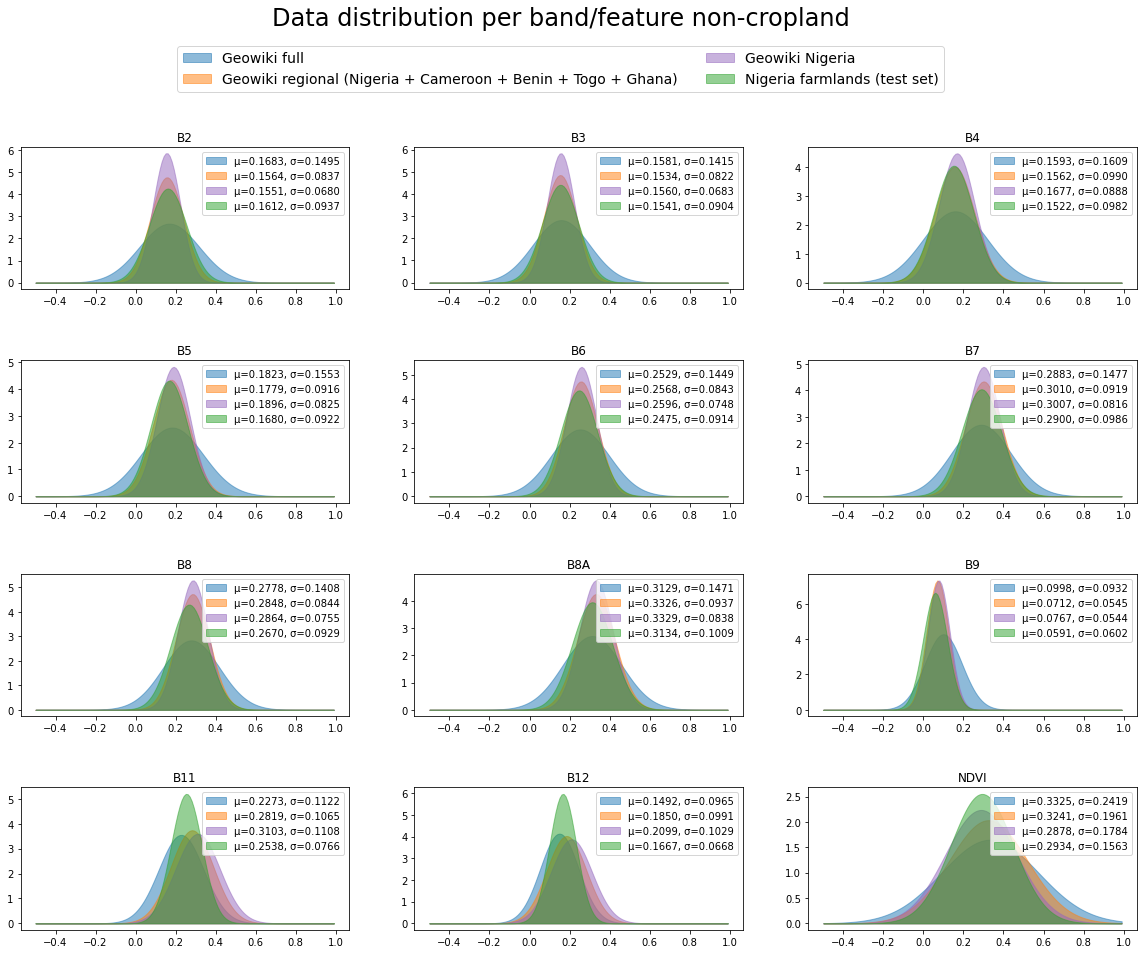

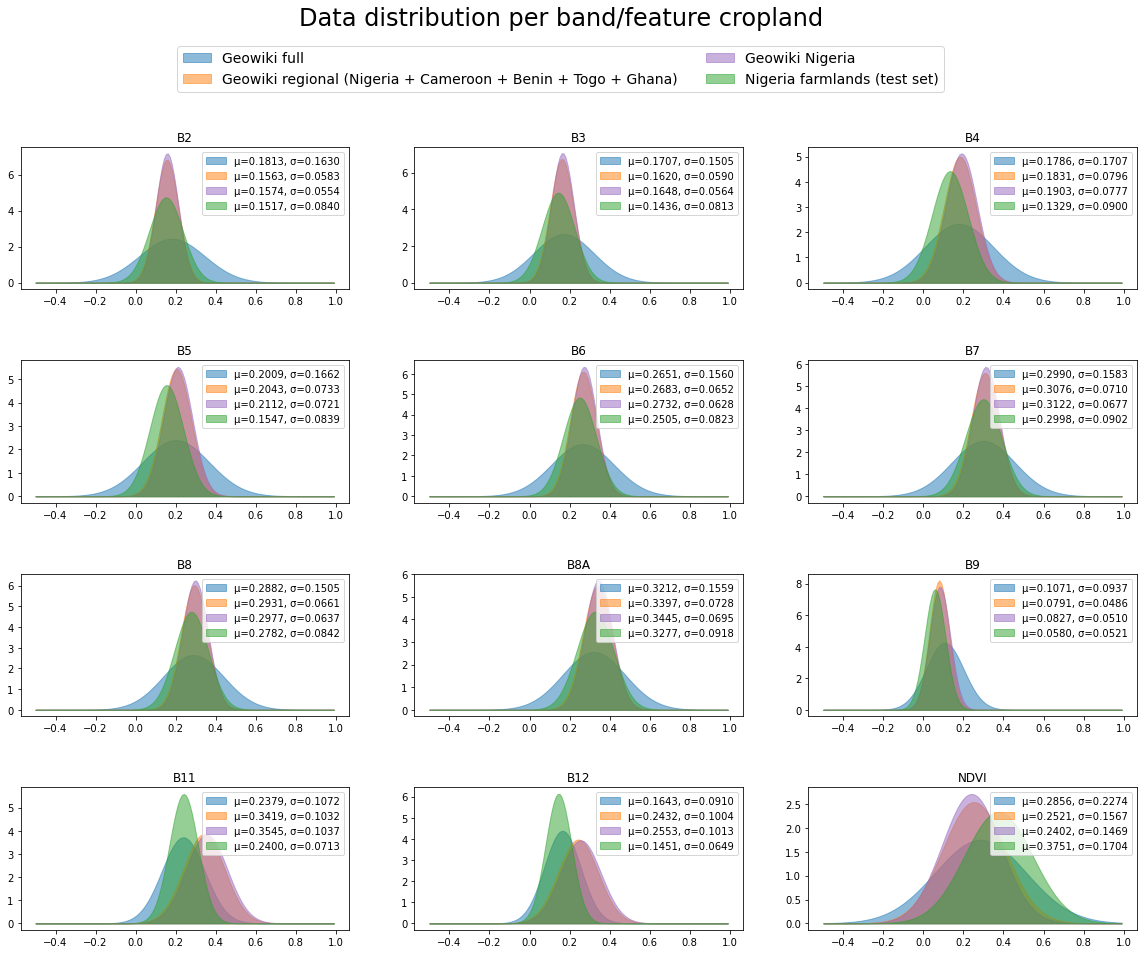

In [38]:
plot_band_distributions_per_class(bands, means_all, stdevs_all, labels, colors, per_class=True)

<font color='magenta'>
    <ul> 
        <li> Overall cropland class has less variability.
        <li> Geowiki Nigeria is much closer to test distribution for both classes. However, some bands are different due to sampling bias of Nigeria farmlands (no points in the North dessert), and shift of year. 
        <li> For most bands the test set has a slightly higher variability than Geowiki Nigeria for both classes.
        <li> Distribution of neighbouring countries to Nigeria seems to even be a bit closer to the test distribution for most bands.
        <li> Crop distribution from neighbouring countries to Nigeria are almost the same, so adding them to the training set should be good.
    </ul>    
</font>

TODOs:
- Get n of samples from normalizing dict and show on plot